# LASSO regression

Last updated: 02-01-2024.

Code for performing LASSO regression (& generating Fig. 4A & Extended Data Figure 4-1).

This notebook contains part of the analysis pipeline and figures for the following manuscript: Maboudian et al., JNeurosci 2024. Defining overlooked structures reveals new associations between cortex and cognition in aging and Alzheimer’s disease (accepted).

For simplicity, this notebook references cleaned and formatted data from .csv files included in this repository. If you have any questions about the data please contact the corresponding author (Samira Maboudian).

# load packages & data

In [1]:
## packages ##
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

%matplotlib inline
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatches

import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d 

# import from sklearn CV and lasso
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.linear_model import Lasso
loo = LeaveOneOut()


In [2]:
## load data: wide df of thickness values for sulci, with cog (uwnpsych) scores -- hemis separate
df_npsych_morph_wide_thickness = pd.read_csv(
    'data/df_wide_npsych_demog_cortical-thickness-mean_CN72_AD72_forLASSO_final.csv')
df_npsych_morph_wide_thickness.head()


,Unnamed: 0,Subject,Group,Age,PTEDUCAT,Sex_binary,hemi,closest UWNPSYCH ADNI_MEM score,closest UWNPSYCH ADNI_EF score,icgs-p,...,mcgs,pos,prculs-d,prculs-v,prcus-a,prcus-i,prcus-p,spls,sspls-d,sspls-v
0,0,033_S_1016,CN,89.0,13.0,1,lh,0.676,0.428,NaN,...,2.001,2.163,1.809,2.452,2.249,2.049,2.719,2.344,2.623,2.976
1,1,033_S_1016,CN,89.0,13.0,1,rh,0.676,0.428,NaN,...,2.043,2.140,2.314,NaN,1.888,2.440,2.233,2.449,2.809,2.821
2,2,033_S_5017,AD,84.0,18.0,0,lh,-1.200,-0.881,2.775,...,2.005,2.121,1.849,NaN,2.001,1.995,2.443,2.424,NaN,NaN
3,3,033_S_5017,AD,84.0,18.0,0,rh,-1.200,-0.881,3.888,...,2.095,2.285,1.949,NaN,2.097,2.024,1.961,2.512,NaN,NaN
4,4,022_S_6069,CN,75.0,18.0,1,lh,1.355,0.422,3.770,...,2.265,2.385,2.134,2.619,2.005,2.289,2.102,2.372,3.000,NaN


In [3]:
## load data: wide df of thickness values for sulci, with cog (uwnpsych) scores -- hemis combined
df_npsych_morph_wide_thickness_bothHem = pd.read_csv(
    'data/df_wide_npsych_demog_cortical-thickness-mean_both-hemis_CN72_AD72_forLASSO_final.csv')
df_npsych_morph_wide_thickness_bothHem.head()


,Unnamed: 0,Subject,Group,Group_bin,closest UWNPSYCH ADNI_MEM score,PTEDUCAT,Sex_binary,Age,icgs-p_lh,ifrms_lh,...,mcgs_rh,pos_rh,prculs-d_rh,prculs-v_rh,prcus-a_rh,prcus-i_rh,prcus-p_rh,spls_rh,sspls-d_rh,sspls-v_rh
0,0,033_S_1016,CN,1,0.676,13.0,1,89.0,NaN,3.128,...,2.043,2.140,2.314,NaN,1.888,2.440,2.233,2.449,2.809,2.821
1,1,033_S_5017,AD,0,-1.200,18.0,0,84.0,2.775,2.629,...,2.095,2.285,1.949,NaN,2.097,2.024,1.961,2.512,NaN,NaN
2,2,022_S_6069,CN,1,1.355,18.0,1,75.0,3.770,3.117,...,2.147,2.321,2.255,2.839,2.113,2.171,2.367,2.329,2.854,2.462
3,3,007_S_4488,CN,1,1.061,18.0,0,79.0,NaN,3.129,...,2.092,2.268,2.157,2.476,2.162,2.196,2.943,2.286,3.190,3.021
4,4,033_S_5013,AD,0,-0.897,18.0,1,68.0,NaN,2.932,...,2.064,2.268,2.294,2.090,2.199,1.954,2.401,2.275,2.764,2.179


# LASSO Regression

###  LASSO functions

In [4]:
## Lasso ##
def lasso_(Xr, yr, alpha_vals, n_folds = loo):
    ''''
        Determine best paramters for LASSO regression and fit model
        input
        ----------
        Xr = predictors 
        yr = DV
        alpha_vals = array of possible alpha values to test 
        n_folds = folds for cross-validation. Default is loo
        Returns
        --------
        depth values as an array     
    '''

    # determine the alpha-value that minimizes MSE with GridSearchCV.
    lasso = Lasso()
    lasso_regressor = GridSearchCV(lasso, alpha_vals, scoring = 'neg_mean_squared_error', cv = n_folds)
    lasso_regressor.fit(Xr, yr)

    # best alpha and MSE
    best_alpha = lasso_regressor.best_params_
    best_MSE = lasso_regressor.best_score_

    # fit the best model
    best_model = lasso_regressor.best_estimator_
    best_model.fit(Xr,yr)
    best_model.predict(Xr)
    
    #best_model.score_
    return best_alpha, best_MSE, best_model.coef_, lasso_regressor.cv_results_['params'], lasso_regressor.cv_results_['mean_test_score']



In [5]:
def lasso_df_setup_and_run(df, variable_sulci, predictors_Xr, DV_yr, alphas):
    """runs LASSO regression with multiple alpha parameters and 
    returns final model coeffs"""
    
    ## Separate data by hemisphere ## 
    RH_df = df[df["hemi"] == 'rh']
    LH_df = df[df["hemi"] == 'lh']
    
    ## remove variable sulci
    RH_df = RH_df.drop(columns=variable_sulci)
    LH_df = LH_df.drop(columns=variable_sulci)
    
    ## drop any missing
    RH_df = RH_df.dropna()
    LH_df = LH_df.dropna()
    
    
    ## run LASSO: RH ##
    print('### RH LASSO: ###')
    print('num sub: ', len(RH_df))
    print('num sub CN: ', len(RH_df[RH_df['Group']=='CN']))
    print('num sub AD: ', len(RH_df[RH_df['Group']=='AD']))
    rh_lasso = lasso_(RH_df[predictors_Xr], RH_df[DV_yr], alphas)
    
    ## best RH model:
    # alpha
    print('alpha:')
    print(rh_lasso[0])
    # neg MSE 
    print('neg MSE:')
    print(rh_lasso[1])
    # beta-vals
    print('beta vals:')
    print(rh_lasso[2])
    
    
    ## run LASSO: LH ##
    print('### LH LASSO: ###')
    print('num sub: ', len(LH_df))
    print('num sub CN: ', len(LH_df[LH_df['Group']=='CN']))
    print('num sub AD: ', len(LH_df[LH_df['Group']=='AD']))
    lh_lasso = lasso_(LH_df[predictors_Xr], LH_df[DV_yr], alphas)
    
    ## best LH model:
    # alpha
    print('alpha:')
    print(lh_lasso[0])
    # neg MSE 
    print('neg MSE:')
    print(lh_lasso[1])
    # beta-vals
    print('beta vals:')
    print(lh_lasso[2])
    
    return [rh_lasso, lh_lasso]


def lasso_df_setup_and_run_forplot(df, variable_sulci, predictors_Xr, DV_yr, alphas, n_folds = loo):
    """runs LASSO regression with multiple alpha parameters and 
    returns final model coeffs, MSE scores, and alpha values,
    set up to make plotting easier"""
    
    ## Separate data by hemisphere ## 
    RH_df = df[df["hemi"] == 'rh']
    LH_df = df[df["hemi"] == 'lh']
    
    ## remove variable sulci
    RH_df = RH_df.drop(columns=variable_sulci)
    LH_df = LH_df.drop(columns=variable_sulci)
    
    ## drop any missing rows
    RH_df = RH_df.dropna()
    LH_df = LH_df.dropna()
    

    coefs_rh = []
    coefs_rh2 = []
    scores_rh = []
    
    for a in alphas['alpha']:
        lasso_i = Lasso(alpha=a)
        lasso_i.fit(RH_df[predictors_Xr], RH_df[DV_yr])
        coefs_rh += [[a]+lasso_i.coef_.tolist()]
    
        alpha_dict = {'alpha': [a]}
        lasso_analysis = lasso_(RH_df[predictors_Xr], RH_df[DV_yr], alpha_dict)
        coefs_val = lasso_analysis[2]
        mse_val = lasso_analysis[1]
        alpha_val = lasso_analysis[0].get('alpha', 999)
        coefs_rh2 += [[a]+coefs_val]
        scores_rh += [mse_val]
    
    coefs_lh = []
    coefs_lh2 = []
    scores_lh = []
    
    for a in alphas['alpha']:
        lasso_i = Lasso(alpha=a)
        lasso_i.fit(LH_df[predictors_Xr], LH_df[DV_yr])
        coefs_lh += [[a]+lasso_i.coef_.tolist()]
        lasso_i.score
        
        alpha_dict = {'alpha': [a]}
        lasso_analysis = lasso_(LH_df[predictors_Xr], LH_df[DV_yr], alpha_dict)
        coefs_val = lasso_analysis[2]
        mse_val = lasso_analysis[1]
        alpha_val = lasso_analysis[0].get('alpha', 999)
        coefs_lh2 += [[a]+coefs_val]
        scores_lh += [mse_val]
    
    return [coefs_rh, coefs_lh],  [scores_rh, scores_lh], [coefs_rh2, coefs_lh2]

In [6]:
# combine hemis

def lasso_df_setup_and_run_BothHemis(df, variable_sulci, predictors_Xr, DV_yr, alphas):
    """runs LASSO regression with multiple alpha parameters and 
    returns final model coeffs"""
    
    ## remove variable sulci
    df = df.drop(columns=variable_sulci)
    
    ## drop any missing
    df = df.dropna()    
    
    ## run LASSO: RH+LH ##
    print('### RH & LH LASSO: ###')
    print('num sub: ', len(df))
    print('num sub CN: ', len(df[df['Group']=='CN']))
    print('num sub AD: ', len(df[df['Group']=='AD']))
    rhlh_lasso = lasso_(df[predictors_Xr], df[DV_yr], alphas)
    
    ## best RH+LH model:
    # alpha
    print('alpha:')
    print(rhlh_lasso[0])
    # neg MSE 
    print('neg MSE:')
    print(rhlh_lasso[1])
    # beta-vals
    print('beta vals:')
    print(rhlh_lasso[2])
    
    return [rhlh_lasso]


def lasso_df_setup_and_run_forplot_BothHemis(df, variable_sulci, predictors_Xr, DV_yr, alphas, n_folds = loo):
    """runs LASSO regression with multiple alpha parameters and 
    returns final model coeffs, MSE scores, and alpha values,
    set up to make plotting easier"""
    
    bothHem_df = df.copy()
    
    ## remove variable sulci
    bothHem_df = bothHem_df.drop(columns=variable_sulci)
    
    ## drop any missing rows
    bothHem_df = bothHem_df.dropna()
    
    coefs_bothHem = []
    coefs_bothHem2 = []
    scores_bothHem = []
    
    for a in alphas['alpha']:
        lasso_i = Lasso(alpha=a)
        lasso_i.fit(bothHem_df[predictors_Xr], bothHem_df[DV_yr])
        coefs_bothHem += [[a]+lasso_i.coef_.tolist()]
    
        alpha_dict = {'alpha': [a]}
        lasso_analysis = lasso_(bothHem_df[predictors_Xr], bothHem_df[DV_yr], alpha_dict)
        coefs_val = lasso_analysis[2]
        mse_val = lasso_analysis[1]
        alpha_val = lasso_analysis[0].get('alpha', 999)
        coefs_bothHem2 += [[a]+coefs_val]
        scores_bothHem += [mse_val]
    
    return [coefs_bothHem],  [scores_bothHem], [coefs_bothHem2]

### run LASSO

In [7]:
# run lasso:

# set up df: only include MEM score
df_npsych_morph_wide_thickness_mem=df_npsych_morph_wide_thickness.copy()
df_npsych_morph_wide_thickness_mem.drop(columns=[
                    'closest UWNPSYCH ADNI_EF score'
                    ], inplace=True) #remove columns youre not using

#specify variable sulci (to be removed -- everyone needs to have the same predictors)
variable_sulc = ['icgs-p', 'sspls-d', 'prculs-v']

#specify predictors (Xr), DV (yr), and alpha values
Xr = ['pos','prculs-d','prcus-p','prcus-i','prcus-a','spls','mcgs','ifrms','sspls-v']
yr = ['closest UWNPSYCH ADNI_MEM score']
alpha = {'alpha':[3e-3, 1e-2, 2e-2, 2.5e-2, 3e-2, 3.5e-2, 5e-2, 7e-2, 9e-2, 
                  1e-1, 3e-1, 5e-1, 7e-1, 9e-1, 1, 3, 5, 10, 1e3]}


In [8]:
#run LASSO
print('MEM: ', 'CN+AD,', 'thickness')
lasso_df_setup_and_run(df_npsych_morph_wide_thickness_mem, variable_sulc, Xr, yr, alpha);


MEM:  CN+AD, thickness
### RH LASSO: ###
num sub:  70
num sub CN:  40
num sub AD:  30
alpha:
{'alpha': 0.02}
neg MSE:
-0.869095040400942
beta vals:
[ 0.          0.53902091  0.37668624 -0.         -0.          0.
  0.          0.47442215  0.94673334]
### LH LASSO: ###
num sub:  106
num sub CN:  58
num sub AD:  48
alpha:
{'alpha': 0.02}
neg MSE:
-1.0266124345255372
beta vals:
[ 0.6777844   0.          0.07639768  0.          0.          0.70659277
  0.         -0.          0.5325632 ]


In [9]:
# run LASSO to setup for plots
lasso_for_plot_ADCN = lasso_df_setup_and_run_forplot(df_npsych_morph_wide_thickness_mem, 
                                                     variable_sulc, Xr, yr, alpha);


MEM:  CN+AD, thickness (rh)


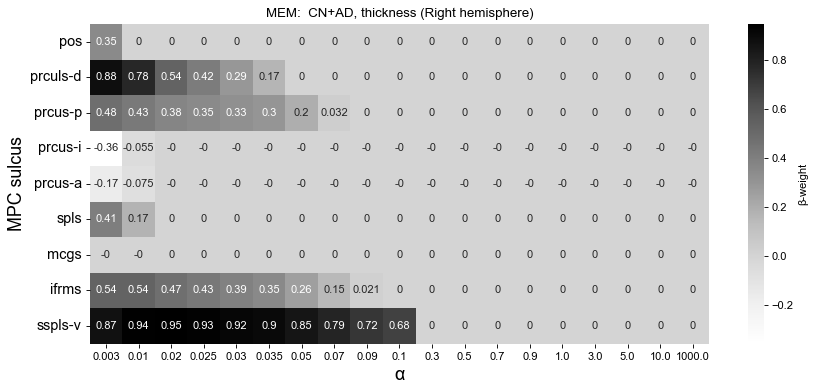

In [10]:
# beta coeffs plot : Right Hemisphere
print('MEM: ', 'CN+AD,', 'thickness', '(rh)')

coefs = lasso_for_plot_ADCN[0]
coefs_rh = coefs[0]
coefs_lh = coefs[1]

ylabs=['pos',  'prculs-d',  'prcus-p',  'prcus-i',  'prcus-a',  'spls',  
               'mcgs',  'ifrms' ,'sspls-v']  

coefs_rh_df = pd.DataFrame(data=coefs_rh, columns=['alpha']+Xr)
coefs_rh_df=coefs_rh_df.set_index('alpha').transpose()

fig,ax = plt.subplots(figsize=(11, 5), dpi=80)
ax = sns.heatmap(coefs_rh_df, annot=True, cmap='Greys', cbar_kws={'label': 'β-weight'},
                yticklabels = ylabs)
plt.title('MEM:  CN+AD, thickness (Right hemisphere)')
plt.ylabel('MPC sulcus', fontsize=16)
plt.yticks(fontsize=13)
plt.xlabel('α', fontsize=16)

fig.tight_layout()


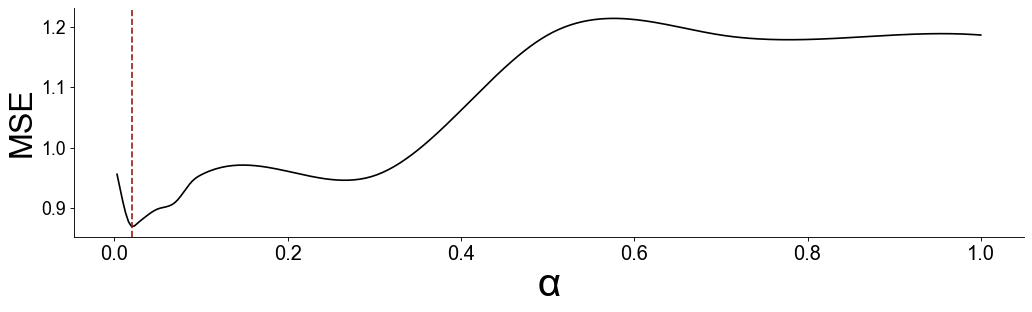

In [11]:
# MSE vs. alpha plot: Right hemisphere

# create df of alpha vs MSE values
alpha = {'alpha':[3e-3, 1e-2, 2e-2, 2.5e-2, 3.5e-2, 5e-2, 7e-2, 
                  9e-2, 1e-1, 3e-1, 5e-1, 7e-1, 9e-1, 1, 3, 5, 10]}

ADCN_MSEs_rh = lasso_for_plot_ADCN[1][0][:-3]
ADCN_MSEs_rh = [-1*i for i in ADCN_MSEs_rh]
alphas = alpha['alpha'][:-3]
log_alphas = [np.log(a) for a in alphas]

ADCN_MSE_alphas_rh = list(zip(alphas, ADCN_MSEs_rh))

## create the df
ADCN_MSEs_rh_df = pd.DataFrame(data=ADCN_MSE_alphas_rh, columns=['α', 'MSE'])
ADCN_MSEs_rh_df['log(α)']=log_alphas

# plot vaues, smoothed
fig,ax = plt.subplots(figsize=(13, 4), dpi=80)

xs = ADCN_MSEs_rh_df['α']
ys = ADCN_MSEs_rh_df['MSE']

xnew = np.linspace(xs.min(), xs.max(), 300)  
f_cubic = interp1d(xs, ys, kind='cubic') #smooth curve

plt.plot(xnew, f_cubic(xnew), label='cubic', color='black')
plt.axvline(x=0.02, linestyle='--', color='#9b1d1d')

plt.xlabel('α', fontsize=36)
plt.ylabel('MSE', fontsize=29)
plt.xticks(fontsize=18)
plt.yticks([0.90,1.00,1.10,1.20],fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.show()
plt.tight_layout();


MEM:  CN+AD, thickness (lh)


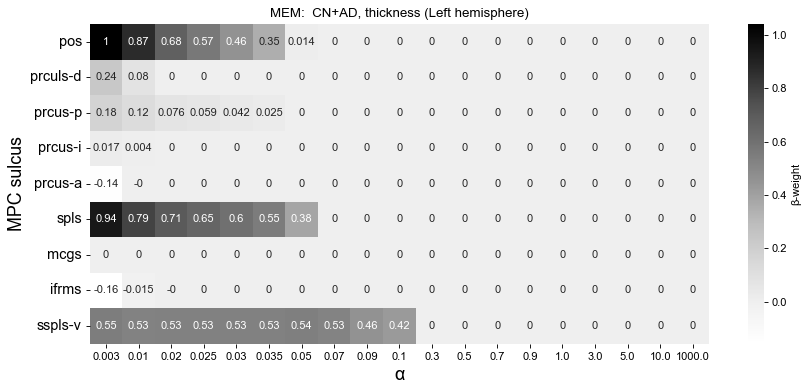

In [12]:
# beta coeffs plot : Left Hemisphere
print('MEM: ', 'CN+AD,', 'thickness', '(lh)')

coefs = lasso_for_plot_ADCN[0]
coefs_lh = coefs[1]

ylabs=['pos',  'prculs-d',  'prcus-p',  'prcus-i',  'prcus-a',  'spls',  
               'mcgs',  'ifrms' ,'sspls-v']

coefs_lh_df = pd.DataFrame(data=coefs_lh, columns=['alpha']+Xr)
coefs_lh_df=coefs_lh_df.set_index('alpha').transpose()

fig,ax = plt.subplots(figsize=(11, 5), dpi=80)
ax = sns.heatmap(coefs_lh_df, annot=True, cmap='Greys', cbar_kws={'label': 'β-weight'},
                yticklabels = ylabs)
plt.title('MEM:  CN+AD, thickness (Left hemisphere)')
plt.ylabel('MPC sulcus', fontsize=16)
plt.xlabel('α', fontsize=16)
plt.yticks(fontsize=13)

fig.tight_layout()


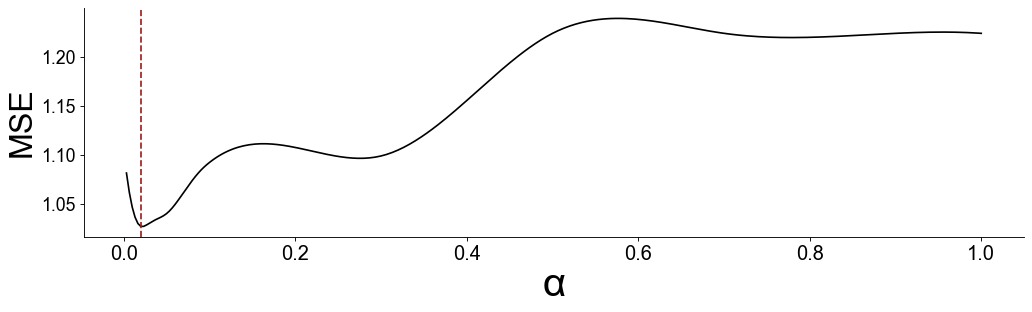

In [13]:
# MSE vs. alpha plot: Left hemisphere

# create df of alpha vs MSE values
alpha = {'alpha':[3e-3, 1e-2, 2e-2, 2.5e-2, 3.5e-2, 5e-2, 7e-2, 
                  9e-2, 1e-1, 3e-1, 5e-1, 7e-1, 9e-1, 1, 3, 5, 10]}
ADCN_MSEs_lh = lasso_for_plot_ADCN[1][1][:-3]
ADCN_MSEs_lh = [-1*i for i in ADCN_MSEs_lh]
alphas = alpha['alpha'][:-3]
log_alphas = [np.log(a) for a in alphas]

ADCN_MSE_alphas_lh = list(zip(alphas, ADCN_MSEs_lh))

## create the df
ADCN_MSEs_lh_df = pd.DataFrame(data=ADCN_MSE_alphas_lh, columns=['α', 'MSE'])
ADCN_MSEs_lh_df['log(α)']=log_alphas

# plot vaues, smoothed
fig,ax = plt.subplots(figsize=(13, 4), dpi=80)

xs = ADCN_MSEs_lh_df['α']
ys = ADCN_MSEs_lh_df['MSE']

xnew = np.linspace(xs.min(), xs.max(), 300)  
f_cubic = interp1d(xs, ys, kind='cubic') #smooth curve

plt.plot(xnew, f_cubic(xnew), label='cubic', color='black')
plt.axvline(x=0.02, linestyle='--', color='#9b1d1d')

plt.xlabel('α', fontsize=36)
plt.ylabel('MSE', fontsize=29)
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.show()
plt.tight_layout();


### run LASSO: both hemis combined


In [14]:
# run lasso:

# set up df: only include MEM
df_npsych_morph_wide_thickness_bothHem_mem=df_npsych_morph_wide_thickness_bothHem.copy()

#specify variable sulci (to be removed -- everyone needs to have the same predictors)
variable_sulc = ['icgs-p_lh', 'sspls-d_lh', 'prculs-v_lh',
                'icgs-p_rh', 'sspls-d_rh', 'prculs-v_rh',]

#specify predictors (Xr), DV (yr), and alpha values
Xr = ['pos_lh','prculs-d_lh','prcus-p_lh','prcus-i_lh','prcus-a_lh','spls_lh','mcgs_lh','ifrms_lh','sspls-v_lh', 
      'pos_rh','prculs-d_rh','prcus-p_rh','prcus-i_rh','prcus-a_rh','spls_rh','mcgs_rh','ifrms_rh','sspls-v_rh', 
      'Group_bin']
yr = ['closest UWNPSYCH ADNI_MEM score']
alpha = {'alpha':[3e-3, 1e-2, 2e-2, 2.5e-2, 3.5e-2, 5e-2, 7e-2, 9e-2, 1e-1, 3e-1, 5e-1, 7e-1, 9e-1, 1, 3, 5, 10]}


In [15]:
#run LASSO bothhem
print('MEM: ', 'CN+AD, both hemis,', 'thickness')
lasso_df_setup_and_run_BothHemis(df_npsych_morph_wide_thickness_bothHem_mem, variable_sulc, Xr, yr, alpha);


MEM:  CN+AD, both hemis, thickness
### RH & LH LASSO: ###
num sub:  54
num sub CN:  33
num sub AD:  21
alpha:
{'alpha': 0.02}
neg MSE:
-0.3065982113938872
beta vals:
[ 0.          0.          0.         -0.         -0.          0.
  0.         -0.         -0.18718249  0.          0.          0.02161593
  0.         -0.          0.28026879  0.          0.22612143  0.11107942
  1.84868151]


In [16]:
#run LASSO for plots
lasso_for_plot_ADCN = lasso_df_setup_and_run_forplot_BothHemis(df_npsych_morph_wide_thickness_bothHem_mem, 
                                                     variable_sulc, Xr, yr, alpha);


MEM:  CN+AD, thickness (both)


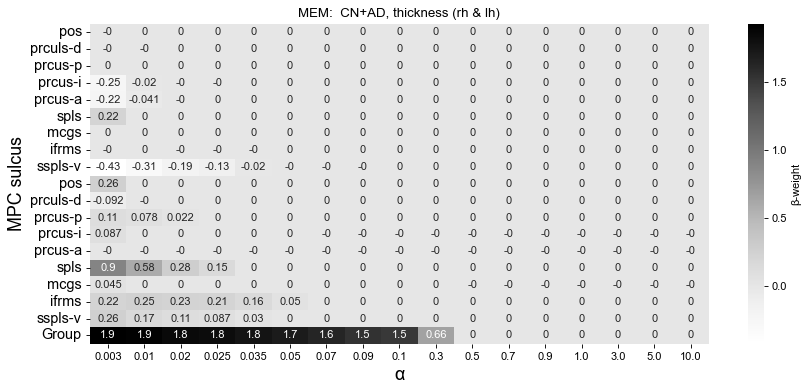

In [17]:
# beta coeffs plot : Both hemispheres
print('MEM: ', 'CN+AD,', 'thickness', '(both)')
ylabs = ['pos', 'prculs-d', 'prcus-p', 'prcus-i', 'prcus-a', 'spls', 'mcgs', 'ifrms', 'sspls-v', 
         'pos', 'prculs-d', 'prcus-p', 'prcus-i', 'prcus-a', 'spls', 'mcgs', 'ifrms', 'sspls-v', 'Group']

coefs = lasso_for_plot_ADCN[0]
coefs_bothHem = coefs[0]

coefs_bothHem_df = pd.DataFrame(data=coefs_bothHem, columns=['alpha']+Xr)
coefs_bothHem_df=coefs_bothHem_df.set_index('alpha').transpose()

fig,ax = plt.subplots(figsize=(11, 5), dpi=80)
ax = sns.heatmap(coefs_bothHem_df, annot=True, cmap='Greys', cbar_kws={'label': 'β-weight'},
                yticklabels=ylabs)
                #yticklabels = ylabs)
plt.title('MEM:  CN+AD, thickness (rh & lh)')
plt.ylabel('MPC sulcus', fontsize=16)
plt.yticks(fontsize=13)
plt.xlabel('α', fontsize=16)

fig.tight_layout()


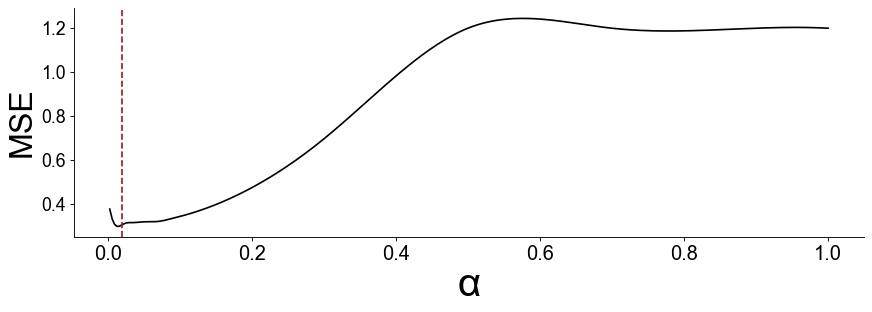

In [18]:
# MSE vs. alpha plot: Both hemisphere

# create df of alpha vs MSE values

alpha = {'alpha':[3e-3, 1e-2, 2e-2, 2.5e-2, 3.5e-2, 5e-2, 7e-2, 9e-2, 
                  1e-1, 3e-1, 5e-1, 7e-1, 9e-1, 1, 3, 5, 10]}

ADCN_MSEs_bothHem = lasso_for_plot_ADCN[1][0][:-3]
ADCN_MSEs_bothHem = [-1*i for i in ADCN_MSEs_bothHem]
alphas = alpha['alpha'][:-3]
log_alphas = [np.log(a) for a in alphas]

ADCN_MSE_alphas_bothHem = list(zip(alphas, ADCN_MSEs_bothHem))

# Create the df
ADCN_MSEs_bothHem_df = pd.DataFrame(data=ADCN_MSE_alphas_bothHem, columns=['α', 'MSE'])
ADCN_MSEs_bothHem_df['log(α)']=log_alphas

fig,ax = plt.subplots(figsize=(11, 4), dpi=80)

xs = ADCN_MSEs_bothHem_df['α']
ys = ADCN_MSEs_bothHem_df['MSE']

xnew = np.linspace(xs.min(), xs.max(), 300)  
f_cubic = interp1d(xs, ys, kind='cubic') 

plt.plot(xnew, f_cubic(xnew), label='cubic', color='black')
plt.axvline(x=0.02, linestyle='--', color='#9b1d1d')

plt.xlabel('α', fontsize=36)
plt.ylabel('MSE', fontsize=29)
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.show()
plt.tight_layout();
